In [1]:
# IMPORTS #
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model


2025-07-01 01:18:52.936392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751357932.947614    6805 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751357932.951045    6805 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751357932.960111    6805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751357932.960119    6805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751357932.960120    6805 computation_placer.cc:177] computation placer alr

In [2]:
# CONSTANTS #

IMAGE_X = 300
IMAGE_Y = 300

GAUSSIAN_X = 48
GAUSSIAN_Y = 48

SCALE_FACTOR = 8

LABEL_X = IMAGE_X // SCALE_FACTOR
LABEL_Y = IMAGE_Y // SCALE_FACTOR

# Range for Random Gen
MIN_NUM_GAUSSIANS = 2
MAX_NUM_GAUSSIANS = 5

MIN_STD_X = 5
MAX_STD_X = 15

MIN_STD_Y = 5
MAX_STD_Y = 15

MIN_THETA = 0
MAX_THETA = np.pi

MIN_INTENSITY = 0.05
MAX_INTENSITY = 0.7

THRESHOLD = 0.5


In [32]:
# Generate Gaussian Functions
def img_gen(VERBOSE: bool = False) -> tuple:

    img = np.zeros(shape=(IMAGE_Y, IMAGE_X, 1))
    label = np.zeros(shape=(LABEL_Y, LABEL_X, 1))
    params = []

    num_gaussians = np.random.randint(low=MIN_NUM_GAUSSIANS, high=MAX_NUM_GAUSSIANS)
    for gaussian in range(num_gaussians):

        # Randomize params
        center_x = np.random.randint(low=0 + GAUSSIAN_X // 2, high=IMAGE_X - GAUSSIAN_X // 2)
        center_y = np.random.randint(low=0 + GAUSSIAN_Y // 2, high=IMAGE_Y - GAUSSIAN_Y // 2)

        std_x = np.random.randint(low=MIN_STD_X, high=MAX_STD_X)
        std_y = np.random.randint(low=MIN_STD_Y, high=MAX_STD_Y)
        theta = np.random.randint(low=MIN_THETA, high=MAX_THETA)
        
        intensity = np.random.uniform(low=MIN_INTENSITY, high=MAX_INTENSITY)
        
        # Generate Gaussian
        params.append((center_x, center_y, std_x, std_y, theta, intensity))
        gaussian = gaussian_gen(center_x, center_y, std_x, std_y, theta)

        # Add Gaussian to img
        img += intensity * gaussian
        # img += gaussian
        
        label_x = center_x // SCALE_FACTOR
        label_y = center_y // SCALE_FACTOR

        label[label_y, label_x] = 1

    # Convert to 8 bit int
    img = (img * 255).astype(np.uint8)

    # DEBUG
    if VERBOSE:
        # print(f"[Image Shape]: {str(img.shape)}")
        # print(f"[Label Shape]: {str(label.shape)}")
        print(f"[Target Gaussians #]: {str(num_gaussians)}")
        for param in params:
            print(
            f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
            f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
            f"[Theta]: {param[4]:.2f} "
            f"[I]: {param[5]:.2f} "
            )

    return (img, label, params)

def gaussian_gen(center_x: int, center_y: int, std_x: int, std_y: int, theta: float) -> np.ndarray:
    X = np.arange(0, IMAGE_X, 1)
    Y = np.arange(0, IMAGE_Y, 1)
    X, Y = np.meshgrid(X, Y)

    cos_theta_sqrd = np.pow(np.cos(theta),2)
    sin_theta_sqrd = np.pow(np.sin(theta),2)
    sin_cos_theta = np.sin(theta) * np.cos(theta)

    std_x_sqrd = np.pow(std_x, 2)
    std_y_sqrd = np.pow(std_y, 2)

    a = (cos_theta_sqrd) / (2 * std_x_sqrd) + (sin_theta_sqrd) / (2 * std_y_sqrd)
    b = -1 * (sin_cos_theta) / (2 * std_x_sqrd) + (sin_cos_theta) / (2 * std_y_sqrd)
    c = (sin_theta_sqrd) / (2 * std_x_sqrd) + (cos_theta_sqrd) / (2 * std_y_sqrd)

    gaussian = np.exp(-(a * (X - center_x)**2 + 2*b * (X - center_x) * (Y - center_y) + c * (Y - center_y)**2))

    return np.expand_dims(gaussian, -1)

def img_shift():
    pass

def img_scale():
    pass

def img_visualization_one(img: np.ndarray, label: np.ndarray, params: list = None, threshold: int = THRESHOLD) -> None:
    rgb_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Coords of Gaussians:
    for x in range(LABEL_X):
        for y in range(LABEL_Y):
            if label[y, x,] >= threshold:
                
                top_left = (x * SCALE_FACTOR - GAUSSIAN_X // 2, y * SCALE_FACTOR - GAUSSIAN_Y // 2)
                bottom_right = (x * SCALE_FACTOR + GAUSSIAN_X // 2, y * SCALE_FACTOR + GAUSSIAN_Y // 2)
                color = (0, 200, 200)
                thickness = 2
                
                cv2.rectangle(rgb_image, top_left, bottom_right, color, thickness)

    if params != None:
        for param in params:
            print(
            f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
            f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
            f"[Theta]: {param[4]:.2f} "
            f"[I]: {param[5]:.2f} "
            )
    
    plt.imshow(rgb_image)



def img_visualization_two(img: np.ndarray, label: np.ndarray, params: list = None) -> None:
    
    if params != None:
        for param in params:
            print(
            f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
            f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
            f"[Theta]: {param[4]:.2f} "
            f"[I]: {param[5]:.2f} "
            )

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray')


[(c_x, c_y)]: (118, 159) [(s_x, s_y)]: (13 , 10 ) [Theta]: 2.00 [I]: 0.57 
[(c_x, c_y)]: (170, 31 ) [(s_x, s_y)]: (8  , 10 ) [Theta]: 1.00 [I]: 0.64 
[(c_x, c_y)]: (89 , 41 ) [(s_x, s_y)]: (10 , 8  ) [Theta]: 0.00 [I]: 0.19 
[(c_x, c_y)]: (216, 235) [(s_x, s_y)]: (11 , 10 ) [Theta]: 0.00 [I]: 0.70 


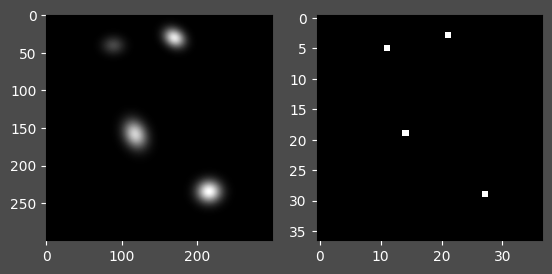

In [4]:
# Test Functions: 
img, label, params = img_gen()
img_visualization_two(img, label, params)
# img_visualization_two(img, label, params)

In [5]:
# Generate Training Data
SAMPLE_COUNT = 10000
img_arr = []
label_arr = []

def process_image():
    img, label, _ = img_gen()
    return img, label

img_arr = []
label_arr = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image) for _ in range(SAMPLE_COUNT)]
    for future in tqdm(as_completed(futures), total=SAMPLE_COUNT):
        img, label = future.result()
        # img_arr.append(img / (np.max(img) + 1)) # Normalize values to [0, 1)
        img_arr.append(img / np.max(img)) # Normalize values to [0, 1]
        label_arr.append(label)

img_arr = np.array(img_arr).astype(np.float32)
label_arr = np.array(label_arr).astype(np.float32)

print(f'[Images Shape]: {img_arr.shape}')
print(f'[Labels Shape]: {label_arr.shape}')

100%|██████████| 10000/10000 [00:38<00:00, 260.78it/s]


[Images Shape]: (10000, 300, 300, 1)
[Labels Shape]: (10000, 37, 37, 1)


In [6]:
# Convert Data to tf DataSet 
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((img_arr, label_arr))
dataset = dataset.shuffle(SAMPLE_COUNT, reshuffle_each_iteration=True)
dataset = dataset.batch(BATCH_SIZE)

I0000 00:00:1751357996.862785    6805 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6619 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
2025-07-01 01:19:56.867167: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3600000000 exceeds 10% of free system memory.
2025-07-01 01:19:57.749034: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3600000000 exceeds 10% of free system memory.


In [7]:
# Model Architecture (INCREASE FILTER SIZE? 16, 32, 64)
input_layer = Input(shape=(IMAGE_X, IMAGE_Y, 1), name='InputLayer')

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform')(input_layer)
x = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05)(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform')(x)
x = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05)(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='lecun_uniform')(x)
x = BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05)(x)
x = ReLU()(x)
x = MaxPool2D(pool_size=2)(x)

x_prob = Conv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid', kernel_initializer='lecun_uniform')(x)

baby_yolo = Model(inputs=input_layer, outputs=x_prob, name='baby_yolo')

In [11]:
# Tensorflow Functions
bce = tf.keras.losses.BinaryCrossentropy()

# def masked_loss(y_true, y_pred):
#     """
#     Compute loss only at locations where y_true == 1.
    
#     Args:
#         y_true: Ground truth labels, shape (batch_size, ...).
#         y_pred: Predicted probabilities, shape (batch_size, ...).
    
#     Returns:
#         Tensor representing the masked loss.
#     """
#     # Clip predictions to avoid log(0) errors
#     y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    
#     # Create a mask for locations where y_true == 1
#     mask = tf.cast(tf.equal(y_true, 1), tf.float32)
    
#     # Compute binary cross-entropy loss
#     bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    
#     # Apply the mask to focus only on locations where y_true == 1
#     masked_loss = mask * bce
    
#     # Compute the mean loss over the masked locations
#     return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

@tf.function
def loss_p(y_true, y_pred):
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)
    

In [12]:
# Training Loop
num_epochs = 20

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=num_epochs,
#     decay_rate=0.9)

lr_schedule = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
baby_yolo.compile(optimizer=adam_optimizer, loss=loss_p, run_eagerly=True)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for batch in tqdm(dataset):
        with tf.GradientTape() as tape:
            prediction = baby_yolo(batch[0])
            loss = loss_p(batch[1], prediction)  # Compute the loss
        grads = tape.gradient(loss, baby_yolo.trainable_variables)
        adam_optimizer.apply_gradients(zip(grads, baby_yolo.trainable_variables))
        running_loss += loss.numpy()
        
    average_loss = running_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")


  0%|          | 0/313 [00:00<?, ?it/s]2025-07-01 01:20:25.973675: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3600000000 exceeds 10% of free system memory.
I0000 00:00:1751358026.500579    6805 cuda_dnn.cc:529] Loaded cuDNN version 90300
100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch [1/20], Loss: 2670.85791015625


100%|██████████| 313/313 [00:17<00:00, 18.12it/s]


Epoch [2/20], Loss: 135.20558166503906


100%|██████████| 313/313 [00:17<00:00, 18.09it/s]


Epoch [3/20], Loss: 117.77980041503906


100%|██████████| 313/313 [00:17<00:00, 18.06it/s]


Epoch [4/20], Loss: 112.62981414794922


100%|██████████| 313/313 [00:17<00:00, 17.99it/s]


Epoch [5/20], Loss: 107.77426147460938


100%|██████████| 313/313 [00:17<00:00, 18.14it/s]


Epoch [6/20], Loss: 103.21060943603516


100%|██████████| 313/313 [00:17<00:00, 18.19it/s]


Epoch [7/20], Loss: 99.56340789794922


100%|██████████| 313/313 [00:17<00:00, 18.20it/s]


Epoch [8/20], Loss: 96.40966796875


100%|██████████| 313/313 [00:17<00:00, 18.26it/s]


Epoch [9/20], Loss: 93.78602600097656


100%|██████████| 313/313 [00:17<00:00, 18.15it/s]


Epoch [10/20], Loss: 91.73655700683594


100%|██████████| 313/313 [00:17<00:00, 18.21it/s]


Epoch [11/20], Loss: 89.43809509277344


100%|██████████| 313/313 [00:17<00:00, 18.22it/s]


Epoch [12/20], Loss: 87.94535064697266


100%|██████████| 313/313 [00:17<00:00, 17.88it/s]


Epoch [13/20], Loss: 85.63146209716797


100%|██████████| 313/313 [00:17<00:00, 18.18it/s]


Epoch [14/20], Loss: 83.61820220947266


100%|██████████| 313/313 [00:17<00:00, 18.10it/s]


Epoch [15/20], Loss: 82.06981658935547


100%|██████████| 313/313 [00:17<00:00, 18.00it/s]


Epoch [16/20], Loss: 80.98432159423828


100%|██████████| 313/313 [00:17<00:00, 18.10it/s]


Epoch [17/20], Loss: 78.04884338378906


100%|██████████| 313/313 [00:17<00:00, 18.23it/s]


Epoch [18/20], Loss: 77.02284240722656


100%|██████████| 313/313 [00:17<00:00, 18.36it/s]


Epoch [19/20], Loss: 75.71345520019531


100%|██████████| 313/313 [00:17<00:00, 18.00it/s]

Epoch [20/20], Loss: 74.85392761230469


In [21]:
VAL_COUNT = 100
img_arr_val = []
label_arr_val = []

def process_image():
    img, label, _ = img_gen()
    return img, label

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image) for _ in range(VAL_COUNT)]
    for future in tqdm(as_completed(futures), total=VAL_COUNT):
        img, label = future.result()
        # img_arr.append(img / (np.max(img) + 1)) # Normalize values to [0, 1)
        img_arr_val.append(img / np.max(img)) # Normalize values to [0, 1]
        label_arr_val.append(label)

img_arr_val = np.array(img_arr).astype(np.float32)
label_arr_val = np.array(label_arr).astype(np.float32)

predictions = baby_yolo(img_arr_val[:50])
print(predictions.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 264.69it/s]


(50, 37, 37, 1)


0.9963857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..200.0].


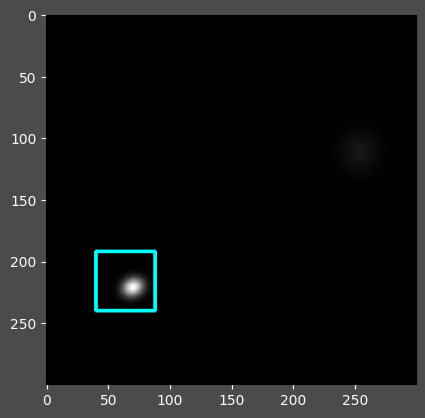

In [36]:
index = np.random.randint(low=0, high=50)
print(np.max(predictions[index]))
img_visualization_one(img_arr_val[index], predictions[index])